In [1]:
import numpy as np
import time
import requests
from copy import deepcopy as dc
from bs4 import BeautifulSoup
from IPython.display import Markdown, display
import itertools
import string
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import numba as nb

# Back to a very old one I've been ignoring for a while. Have come up with a better value than published so must have misunderstood

In [2]:


coords1= [(0, 0), (0, 2), (0, 4), (0, 10), (0, 14), (0, 16), (1, 17), (1, 18), (2, 7), (2, 13), (2, 15),
           (2, 18), (3, 0), (3, 8), (3, 14), (3, 19), (4, 3), (4, 4), (4, 11), (4, 17), (5, 15), (5, 19),
           (6, 12), (7, 7), (7, 15), (7, 18), (8, 19), (9, 0), (9, 3), (11, 15), (12, 4), (12, 7), (13, 11),
           (13, 17), (14, 15), (15, 13), (15, 19), (16, 11), (16, 16), (17, 9), (18, 7), (18, 14),(19, 5), (19, 19)]

In [3]:
#function to print out the grid and swings
def print_coord(coords,start=[],swings=[]):
    grid = np.zeros((20,20))
    for (x,y) in coords:    
        grid[x,y] = 1
    fig,ax = plt.subplots(1,1,figsize=(4,4))
    sns.heatmap(grid,cmap='Greys',cbar=False,linecolor="grey",
            linewidths=0.5,fmt="",annot_kws={"size":10,"weight": "bold"},alpha =0.7)
    for (a,b),(c,d) in swings:
        ax.plot([b+0.5,d+0.5],[a+0.5,c+0.5], linewidth=1,color="r")
    for (a,b),(c,d) in start:
        ax.plot([b+0.5,d+0.5],[a+0.5,c+0.5], linewidth=1,color="g")
    ax.axis('off')  
    plt.show()

In [4]:
#work out the angles for the lines
def to_polar(start,pivot):
    s = np.array(start)
    p = np.array(pivot)
    l = p-s
    r = np.sum(np.power(l,2))
    cosTh = np.dot(l,[-1,0])
    sinTh = np.cross(l,[-1,0])
    a = np.rad2deg(np.arctan2(sinTh,cosTh)+np.pi) % 360
    return r,a

lines = {((x,y),(i,j)):to_polar((x,y),(i,j)) for x,y,i,j in itertools.product(range(20),repeat=4) }

In [5]:
#work out the angles the lines hit the boundary
def edge_hit(c):
    N =20
    not_c = [(i,j) for i,j in itertools.product(range(20),repeat=2) if (i,j) not in c]
    angles = defaultdict(list)
    for a,b in c:
        for i,j in not_c:
            d,angle = lines[((a,b),(i,j))]
            dist = d**.5
            if b+.5 < dist:
                la = np.rad2deg(np.arccos((b+0.5)/dist))
                angles[((a,b),(i,j))] += [270+la,270-la]
            if N-(b+0.5) < dist:
                ra = np.rad2deg(np.arccos((N-(b+0.5))/dist))
                angles[((a,b),(i,j))] += [90+ra,90-ra]
            if a+.5 < dist:
                ta = np.rad2deg(np.arccos((a+0.5)/dist))
                angles[((a,b),(i,j))] += [ta,360-ta]
            if N-(a+0.5) < dist:
                ba = np.rad2deg(np.arccos((N-(a+0.5))/dist))
                angles[((a,b),(i,j))] += [180+ba,180-ba]             
    return angles

edge_angles = edge_hit(coords1)

In [6]:
#work out if a swing is possible given the edges and blocking cells
def between_angle(start_angle,end_angle,block_angles):
    blocks = np.concatenate((block_angles-360,block_angles+0,block_angles+360))
    min_angle = np.max(blocks[blocks <= start_angle])
    max_angle = np.min(blocks[blocks >= start_angle])
    if end_angle >= min_angle and end_angle <= max_angle:
        return True
    if end_angle+360 >= min_angle and end_angle+360 <= max_angle:
        return True
    if end_angle-360 >= min_angle and end_angle-360 <= max_angle:
        return True 
    else:
        return False

In [7]:
#work out all possible swings based on distance and blocking cells
def poss_swing(x,y,coords,lines,edges):  
    poss = []
    scores = []
    for (a,b) in coords:
        distance,start_angle = lines[((x,y),(a,b))]
        blocks = np.array([angle for dist,angle in 
                         [lines[((i,j),(a,b))] for (i,j) in coords if (i,j) !=(a,b)] 
                          if dist < distance ] 
                          + edges[((a,b),(x,y))] 
                          +[-1080,+1080])
        poss += [((a,b),(i,j),distance) for i,j in itertools.product(range(20),repeat=2) 
                 if (i,j) not in coords 
                 and (i,j) != (x,y)          
                 and lines[((i,j),(a,b))][0] == distance
                 and between_angle(start_angle,lines[((i,j),(a,b))][1],blocks)
                 ]
    return poss 

In [28]:
# loop through all paths. Assume it has to pivot via (1,18) and jump to one of the possible cells from there
def solver(target,coords,lines,edges,initial=(19,0)):
    soln = []
    paths=[[initial,coords,0,[],[]]] #current point, coords left,score,path,pivots
    best_score = 1
    
    while len(soln) == 0:
        (x,y),c,s,p,pv = paths.pop(0)
        if s < best_score:
            if (x,y) == target:
                #print([s,p,pv])
                soln = [s,p,pv]
                best_score = np.copy(s)
            else:
                swings = poss_swing(x,y,c,lines,edges)
                for (a,b),(i,j),distance in swings:
                    if distance <5:
                        continue
                    new_c=dc(c)
                    new_c.remove((a,b))
                    new_path = p+[(i,j)]
                    new_pivot = pv+[(a,b)]
                    new_s = s + 1/distance**2
                    paths.append([(i,j),new_c,new_s,new_path,new_pivot])
    return(soln)

In [ ]:
#run the solution and print the score
start = time.time()
initial= (7,18)
score,path,pivots = solver((0,19),coords1,lines,edge_angles,initial)

print("Best Score is {:.4f} in {:.4f} secs".format(score,time.time()-start))
swings = ([[x,pivots[i]] for i,x in enumerate(path)])
starts = [initial]+[i[0] for i in swings[:-1]] 
pivots = [i[1] for i in swings]
print(starts)
print(pivots)
start = [i for i in zip(starts,pivots)]
#print_coord(coords1,start=start,swings=swings)

In [ ]:
#convert solution to submission format
letters =[i for i in string.ascii_lowercase[:20]]
print("Score:{:.4f}".format(score),[i for i in zip([letters[j]+str(20-i) for i,j in pivots],[letters[j]+str(20-i) for ((i,j),(a,b)) in swings])])

In [ ]:
#print the steps
x = [np.sum(np.power(np.array(starts[i],dtype=np.float64)-np.array(pivots[i],dtype=np.float64),2)) for i in range(len(starts))]
print("The distances are: ",x)
print("Checking the score: {:.4f}".format(np.sum(np.power(x,-1))))

grid = np.zeros((20,20))

fig,ax = plt.subplots(2,4,figsize=(16,8))
for i in range(len(start)):
    sns.heatmap(grid,cmap='Greys',cbar=False,linecolor="grey",
                linewidths=1,fmt="",annot_kws={"size":10,"weight": "bold"},ax=ax[i//4,i%4],yticklabels=range(20,0,-1), xticklabels=letters)
    ax[i//4,i%4].tick_params(left=False, bottom=False,labelleft=True, labelright=False,labelsize=6)
    for (a,b),(c,d) in swings[i:i+1]:
        ax[i//4,i%4].plot([b+0.5,d+0.5],[a+0.5,c+0.5], linewidth=1.5,color="r")
    for (a,b),(c,d) in start[i:i+1]:
        ax[i//4,i%4].plot([b+0.5,d+0.5],[a+0.5,c+0.5], linewidth=1.5,color="g")
    for (x,y) in coords1:  
        ax[i//4,i%4].plot(y+0.5,x+0.5,'ko',markersize=1)
        ax[i//4,i%4].set_title("From {} to {} pivot {}".format(starts[i],swings[i][0],swings[i][1]),fontsize=10)         
ax[1,3].axis('off')  
plt.show()

In [ ]:
url='https://www.janestreet.com/puzzles/swing-time-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Markdown("### "+y[8]+"\n\n"+str("\n".join(y[10:14]))))

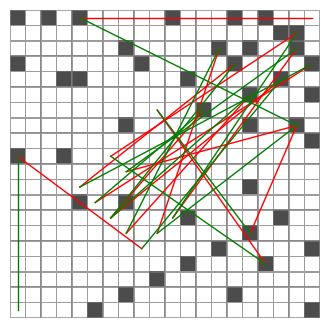

[(19, 0), (15, 8), (13, 6), (11, 4), (12, 5), (13, 6), (14, 7), (14, 9), (10, 7), (13, 10), (9, 6), (6, 9), (7, 18)]
[(9, 0), (4, 17), (3, 14), (3, 19), (6, 12), (5, 15), (2, 13), (7, 18), (2, 18), (1, 18), (16, 16), (14, 15), (0, 4)]
[100.0, 202.0, 164.0, 289.0, 85.0, 145.0, 180.0, 130.0, 185.0, 208.0, 149.0, 100.0, 245.0]
0.08742352425405767


In [12]:
# use the solution provided in the video which doesn't rely on a wrap-around
soln = [("a11","i5"), ("r16","g7"), ("o17","e9"), ("t17","f8"), ("m14","g7"), ("p15","h6"), ("n18","j6"), ("s13","h10"), ("s18","k7"), ("s19","g11"), ("q4","j14"), ("p6","s13"),
("e20","t20")]
letters =[i for i in string.ascii_lowercase[:20]]

swings1 = [((20-int(i[1:]),letters.index(i[0])),(20-int(j[1:]),letters.index(j[0]))) for (j,i) in soln]
starts1 = [(19,0)]+[i[0] for i in swings1[:-1]] 
pivots1 = [i[1] for i in swings1]

start1 = [i for i in zip(starts1,pivots1)]

print_coord(coords1,start=start1,swings=swings1)
print(starts1)
print(pivots1)
x = [np.sum(np.power(np.array(starts1[i],dtype=np.float64)-np.array(pivots1[i],dtype=np.float64),2)) for i in range(len(starts1))]
print(x)
print(np.sum(np.power(x,-1)))

In [ ]:
print(270-np.rad2deg(np.arctan((13-4)/(18-10))),
      270-np.rad2deg(np.arctan((12-4)/(18-9))),
      270-np.rad2deg(np.arctan((11-4)/(18-10))))